In [1]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import terratorch
import torch
import torchgeo 
import tqdm as notebook_tqdm

#import geopandas as gpd
import pandas as pd

import sys
sys.path.append('../')


import utils.basics as bsc
import utils.plotting as pt

import importlib
importlib.reload(pt)

%load_ext autoreload
%autoreload 2

/Users/felix/miniconda3/envs/CHM/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## load the data

In [2]:
# === Paths ===
INPUT_FOLDER = "../data/03_training"

In [ ]:
['BLU', #0
 'BNR', #1
 'EVI', # 
 'GRN',
 'NBR',
 'NDV',
 'NIR',
 'RE1',
 'RE2',
 'RE3',
 'RED',
 'SW1',
 'SW2']
#relevant_s2_band_indices=[0,1,2] ... 

In [4]:
def load_and_split_patches(site, patch_size=32, test_size=0.2, random_state=42, normalize_als=False, s2_band_indices=None):
    """
    Load S2 and ALS patches for a given site, split into train/test sets.
    Optionally normalize ALS patches for training.
    Optionally select specific S2 bands.

    Parameters:
    - site: int (1 or 2)
    - patch_size: int
    - test_size: float
    - random_state: int
    - normalize_als: bool
    - s2_band_indices: list or np.ndarray of int, optional (default: all bands)

    Returns:
    - X_train, X_test, y_train, y_test, als_mean, als_std (mean/std are None if not normalized)
    """
    s2_patches = np.load(os.path.join(INPUT_FOLDER, f"S2_site{site}_px{patch_size}.npy"))
    als_patches = np.load(os.path.join(INPUT_FOLDER, f"ALS_site{site}_px{patch_size}.npy"))
    if s2_band_indices is not None:
        s2_patches = s2_patches[:, s2_band_indices, :, :]
    X_train, X_test, y_train, y_test = train_test_split(
        s2_patches, als_patches, test_size=test_size, random_state=random_state
    )
    als_mean, als_std = None, None
    if normalize_als:
        als_mean = y_train.mean()
        als_std = y_train.std()
        y_train = (y_train - als_mean) / (als_std + 1e-8)
        y_test = (y_test - als_mean) / (als_std + 1e-8)
        print(f"ALS normalization: mean={als_mean:.4f}, std={als_std:.4f}")
    print(f"Site {site}: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Site {site}: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    return X_train, X_test, y_train, y_test, als_mean, als_std

# Example usage with all bands (default)
X_train1, X_test1, y_train1, y_test1, als_mean1, als_std1 = load_and_split_patches(site=1, normalize_als=True)
X_train2, X_test2, y_train2, y_test2, als_mean2, als_std2 = load_and_split_patches(site=2, normalize_als=True)

# Example usage with selected bands, e.g. bands 0, 1, 2
# X_train1, X_test1, y_train1, y_test1, als_mean1, als_std1 = load_and_split_patches(site=1, normalize_als=True, s2_band_indices=[0,1,2])

ALS normalization: mean=29.5905, std=6.1591
Site 1: X_train shape: (156, 13, 32, 32), y_train shape: (156, 32, 32)
Site 1: X_test shape: (40, 13, 32, 32), y_test shape: (40, 32, 32)
ALS normalization: mean=26.4381, std=7.7667
Site 2: X_train shape: (208, 13, 32, 32), y_train shape: (208, 32, 32)
Site 2: X_test shape: (53, 13, 32, 32), y_test shape: (53, 32, 32)


## we wont stack for now, since there are different mean/std in ALS, and we normalize them. 
--> Instead, we use Site 2 for Training+Validation, and Site 1 for testing.

In [4]:
# write a function that stakcs the training and test sets for both sites
def stack_datasets(X_train1, X_test1, y_train1, y_test1, X_train2, X_test2, y_train2, y_test2):
    """
    Stack training and test sets for both sites.

    Parameters:
    - X_train1, X_test1, y_train1, y_test1: Site 1 datasets
    - X_train2, X_test2, y_train2, y_test2: Site 2 datasets

    Returns:
    - Stacked training and test sets
    """
    X_train = np.vstack((X_train1, X_train2))
    X_test = np.vstack((X_test1, X_test2))
    y_train = np.vstack((y_train1, y_train2))
    y_test = np.vstack((y_test1, y_test2))
    
    print(f"Stacked X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Stacked X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = stack_datasets(X_train1, X_test1, y_train1, y_test1, X_train2, X_test2, y_train2, y_test2)

Stacked X_train shape: (543, 13, 32, 32), y_train shape: (543, 32, 32)
Stacked X_test shape: (136, 13, 32, 32), y_test shape: (136, 32, 32)


## sketch the U-Net architecture. 

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import matplotlib.pyplot as plt


In [ ]:
# Central hyperparameter config
config = {
    'patch_size': 32,
    'num_bands': 13,        # change based on input
    'batch_size': 64,
    'lr': 1e-3,
    # 'lr_decay': 1e-5,
    'weight_decay': 5e-5,
    'momentum': 0.9,
    'epochs': 100,
    # 'train_split': 0.7,
    # 'val_split': 0.2,
    # 'test_split': 0.1,
    'huber_delta': 1.0,
    'device':  'mps' if torch.backends.mps.is_available() else 'cpu'
}


Huber Loss vs. MSE


![HUBER-LOSS](image.png)

In [61]:
class S2CanopyHeightDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()               # (N, num_bands, 32, 32)
        self.y = torch.from_numpy(y).float().unsqueeze(1)  # (N, 1, 32, 32)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = S2CanopyHeightDataset(X_train2, y_train2)
val_dataset = S2CanopyHeightDataset(X_test2, y_test2)
test_dataset = S2CanopyHeightDataset(X_train1, y_train1)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'])

In [13]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(128, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        bottleneck = self.bottleneck(self.pool2(enc2))
        dec2 = self.decoder2(torch.cat([self.upconv2(bottleneck), enc2], dim=1))
        dec1 = self.decoder1(torch.cat([self.upconv1(dec2), enc1], dim=1))
        return self.final(dec1)


In [82]:
model = UNet(config['num_bands']).to(config['device'])
criterion = nn.HuberLoss(delta=config['huber_delta'])
optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)

train_losses, val_losses = [], []

for epoch in range(config['epochs']):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(config['device']), targets.to(config['device'])
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(config['device']), targets.to(config['device'])
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if (epoch + 1) % 10 == 0 or epoch == config['epochs'] - 1:
        print(f"Epoch {epoch+1}/{config['epochs']}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    #print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


Epoch 10/100, Train Loss: 0.3170, Val Loss: 0.3362
Epoch 20/100, Train Loss: 0.2755, Val Loss: 0.3059
Epoch 30/100, Train Loss: 0.2653, Val Loss: 0.3107
Epoch 40/100, Train Loss: 0.2604, Val Loss: 0.2969
Epoch 50/100, Train Loss: 0.2557, Val Loss: 0.2915
Epoch 60/100, Train Loss: 0.2568, Val Loss: 0.2913
Epoch 70/100, Train Loss: 0.2517, Val Loss: 0.2900
Epoch 80/100, Train Loss: 0.2465, Val Loss: 0.2881
Epoch 90/100, Train Loss: 0.2618, Val Loss: 0.3122
Epoch 100/100, Train Loss: 0.2459, Val Loss: 0.2895


In [83]:
# denormalize the predictions and targets inside the test_loader
def denormalize(tensor, mean, std):
    return tensor * std + mean


#def evaluate_model(model, test_loader, als_mean, als_std):
def denorm_model(model, test_loader, als_mean2, als_std2):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(config['device']), targets.to(config['device'])
            outputs = model(inputs)
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Denormalize predictions and targets
    all_preds = denormalize(torch.from_numpy(all_preds), als_mean2, als_std2).numpy()
    all_targets = denormalize(torch.from_numpy(all_targets), als_mean2, als_std2).numpy()

    mae = mean_absolute_error(all_targets.flatten(), all_preds.flatten())
    print(f"Test MAE: {mae:.4f}")

    return all_preds, all_targets

# Evaluate the model on the test set
#predictions, targets = denorm_model(model, test_loader, als_mean2, als_std2)
predictions, targets = denorm_model(model, val_loader, als_mean2, als_std2)

Test MAE: 4.8649


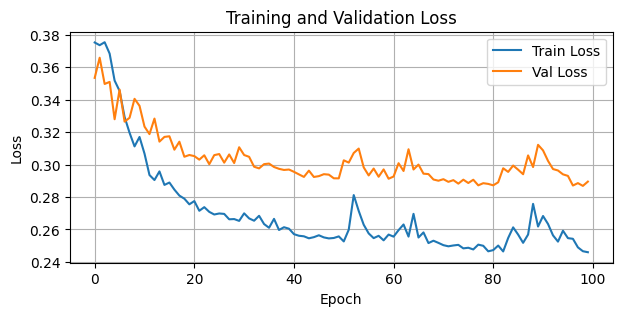

In [84]:
def plot_val_loss(train_losses, val_losses):
    """
    Plot training and validation loss over epochs.
    
    Parameters:
    - train_losses: list of training losses
    - val_losses: list of validation losses
    """
    plt.figure(figsize=(7, 3))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.grid(True)
    plt.show()


plot_val_loss(train_losses, val_losses)


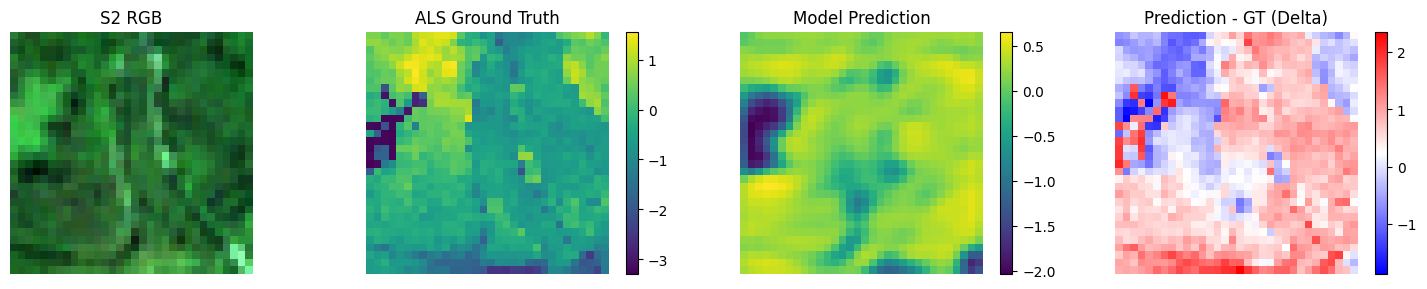

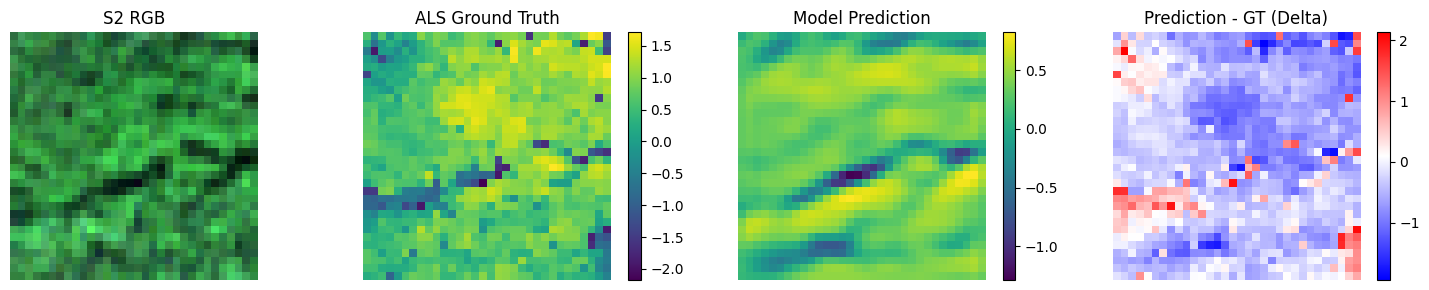

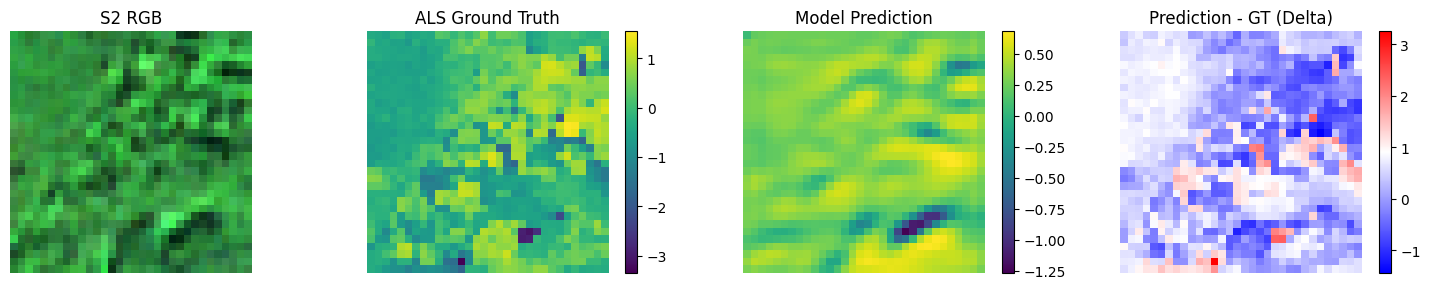

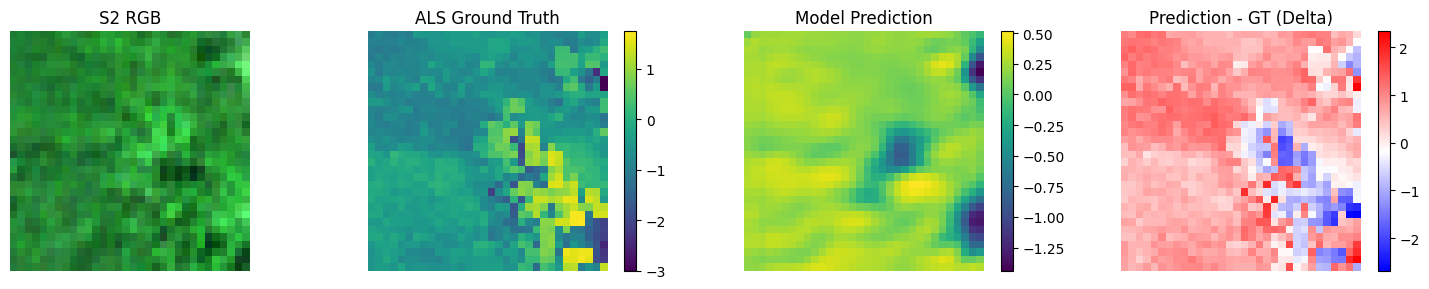

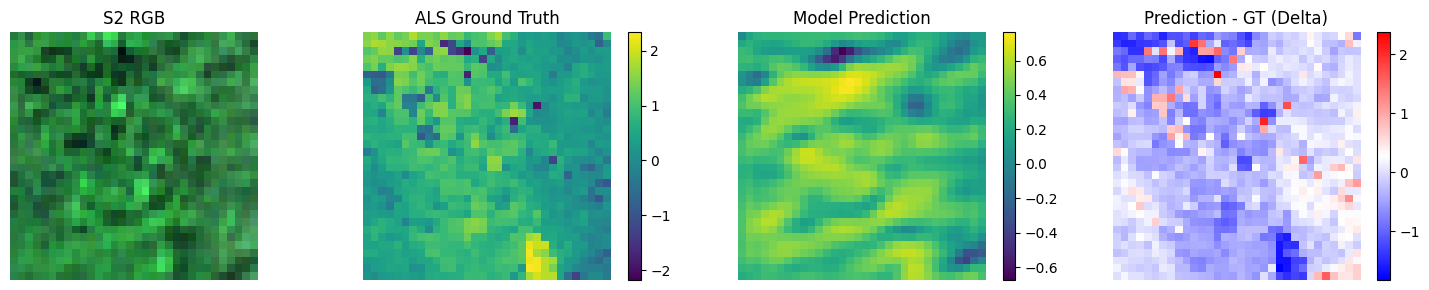

In [85]:
def plot_real_pred_delta(model, dataloader, num_samples=5, device='cpu'):
    """
    Plot S2 RGB, real ALS patches, model predictions, and their delta.

    Parameters:
    - y: np.ndarray, shape (N, 32, 32)
    - model: trained model
    - dataloader: DataLoader for test data
    - num_samples: int, number of samples to plot
    - device: torch device
    """
    model.eval()
    shown = 0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.cpu().numpy()
            preds = model(X_batch).cpu().numpy()
            for i in range(X_batch.shape[0]):
                if shown >= num_samples:
                    return
                # S2 RGB: channels 10, 3, 0 (B, G, R) for Sentinel-2
                rgb = X_batch[i, [10, 3, 0]].cpu().numpy()
                rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)
                rgb = np.transpose(rgb, (1, 2, 0))
                gt = y_batch[i, 0] if y_batch.ndim == 4 else y_batch[i]
                pred = preds[i, 0] if preds.ndim == 4 else preds[i]
                delta = pred - gt
                plt.figure(figsize=(15, 3))
                # S2 RGB
                plt.subplot(1, 4, 1)
                plt.imshow(rgb)
                plt.title("S2 RGB")
                plt.axis('off')
                # ALS GT
                plt.subplot(1, 4, 2)
                plt.title("ALS Ground Truth")
                plt.axis('off')
                im = plt.imshow(gt, cmap='viridis')
                plt.colorbar(im, ax=plt.gca())  
                # pred 
                plt.subplot(1, 4, 3)
                im = plt.imshow(pred, cmap='viridis')
                plt.colorbar(im, ax=plt.gca())  
                plt.title("Model Prediction")
                plt.axis('off')
 
                plt.subplot(1, 4, 4)
                imd = plt.imshow(delta, cmap='bwr')
                plt.title("Prediction - GT (Delta)")
                plt.axis('off')
                plt.colorbar(imd, ax=plt.gca(), location='right')
                plt.tight_layout()
                plt.show()
                shown += 1
                #print(min(delta.flatten()), max(delta.flatten()))

# Example usage:
plot_real_pred_delta(model, val_loader, num_samples=5, device=config['device'])


In [88]:
torch.save(model.state_dict(), "unet_canopy_model2.pth")


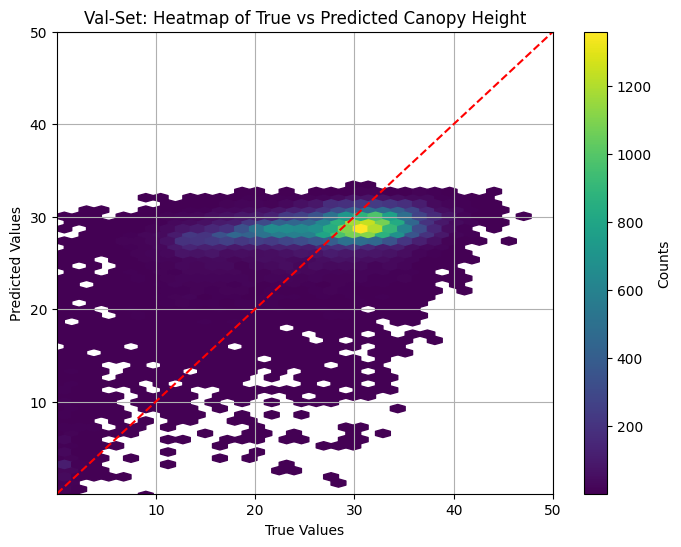

In [86]:
# plot y vs. preds as heatmap
def plot_heatmap(y_true, y_pred, title="Heatmap of True vs Predicted"):
    """
    Plot a heatmap of true vs predicted values.

    Parameters:
    - y_true: np.ndarray, true values
    - y_pred: np.ndarray, predicted values
    - title: str, title of the plot
    """
    plt.figure(figsize=(8, 6))
    plt.hexbin(y_true.flatten(), y_pred.flatten(), gridsize=50, cmap='viridis', mincnt=1)
    plt.colorbar(label='Counts')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
    plt.xlim(y_true.min(), 50)
    plt.ylim(y_true.min(), 50)
    plt.grid(True)
    plt.show()
# Example usage:
plot_heatmap(targets, predictions, title="Val-Set: Heatmap of True vs Predicted Canopy Height")

Test MAE: 12.7024


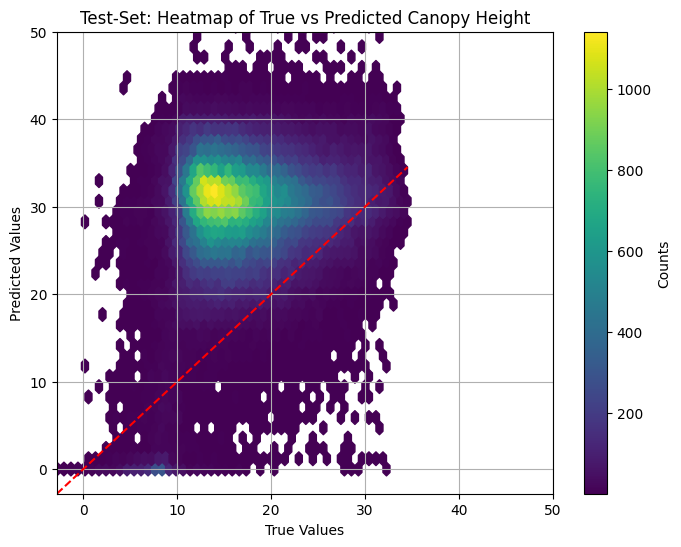

In [87]:
target_test, pred_test = denorm_model(model, test_loader, als_mean1, als_std1)
plot_heatmap(target_test, pred_test, title="Test-Set: Heatmap of True vs Predicted Canopy Height")

Better normalization strategy for bias-compensation: 
- dont compute mean, std for each site 
- rather normnalize for greater area. 
--> Reason: Sites have different height distributions. 
